In [4]:
from uproot_io import Events, View
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt

interaction_dictionary = {}
with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction

In [5]:
filename="projects\CheatedRecoFile_1.root"
events = Events(filename)

In [6]:
def num_particles_in_event(num_event):
    events.event_number[num_event]
    idx = np.where(events.event_number == num_event)
    print("particles",idx[0][0],"to",idx[0][np.size(idx)-1],"in event",num_event)

In [93]:
num_particles_in_event(9309)

particles 515779 to 516044 in event 9309


In [112]:
def plot_event_particle_w(num_particle):
    hits_x_w=np.array([])
    hits_x=np.array([])
    hits_adcs=np.array([])
    for i in range(events.reco_num_hits_w[num_particle]):
        hits_x = np.append(hits_x, events.reco_hits_w[num_particle][i])
        hits_x_w = np.append(hits_x_w, events.reco_hits_x_w[num_particle][i])
        hits_adcs = np.append(hits_adcs, events.reco_adcs_w[num_particle][i])
    hits_bf = np.polyfit(hits_x,hits_x_w,1)
    hits_x_w_fit= [hits_bf[1] + i * hits_bf[0] for i in hits_x]
    #plt.plot([hits_x[0],hits_x[-1]],[hits_x_w_fit[0],hits_x_w_fit[-1]])
    plt.plot(hits_x,hits_x_w_fit)
    plt.scatter(hits_x,hits_x_w,s=8,c=hits_adcs,cmap='hot')
    
        
    
    

In [113]:
def particle_norm_w(num_particle):
    hits_x_w=np.array([])
    hits_x=np.array([])
    for i in range(events.reco_num_hits_w[num_particle]):
        hits_x = np.append(hits_x, events.reco_hits_w[num_particle][i])
        hits_x_w = np.append(hits_x_w, events.reco_hits_x_w[num_particle][i])
    hits_bf = np.polyfit(hits_x,hits_x_w,1)
    hits_x_w_fit= [i * hits_bf[0] + hits_bf[1] for i in hits_x]
    residuals = np.subtract(hits_x_w,hits_x_w_fit)
    rms = np.std(residuals)
    nvariance = np.sum(np.square(residuals))
    rms_div_nhits = rms/np.size(hits_x)
    rms_div_length=rms/abs(hits_x[-1]-hits_x[0])
    return rms,nvariance,rms_div_nhits,rms_div_length
    
    

(0.4050653337020753, 3.6097143404778205, 0.018412060622821604, 0.060403477053770346) 

(0.2658262421322903, 17.31257979651288, 0.0010850050699277155, 0.0020095877562836023)
(0.4050653337020753, 3.6097143404778205, 0.018412060622821604, 0.060403477053770346)


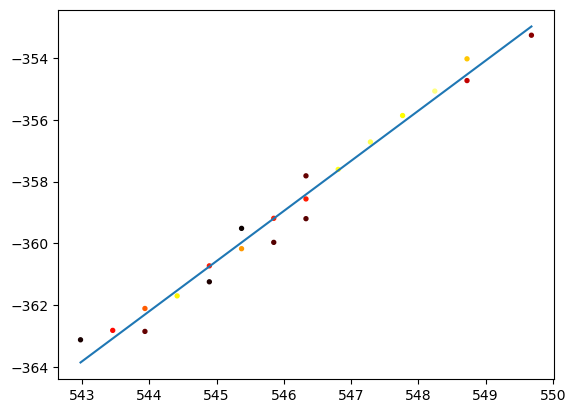

In [114]:

particle = 31

plot_event_particle_w(particle)
print(particle_norm_w(particle),"\n")

# rms has some issues compare particle 29 and 31
# rms particle 40

print(particle_norm_w(29))
print(particle_norm_w(31))


In [94]:
def hist_reco(metric):
    n_particles = 2000
    particle_norms = np.array([])
    for i in range(n_particles):       
        if 300 > events.reco_num_hits_w[i] > 15:
            particle_norms = np.append(particle_norms,particle_norm_w(i)[metric])
    mean = np.mean(particle_norms)
    std = np.std(particle_norms)
    
    print(mean,std)
    # particle filtering
    sensitivity=[mean+6.0*std,mean+2*std,mean+8*std,mean+8*std]
    
    for i in range(np.size(particle_norms)-1):
        if particle_norms[i] > sensitivity[metric]:
            particle_norms[i] = 0
    particle_norms = np.trim_zeros(np.sort(particle_norms))
    plt.hist(particle_norms)
        

0.09253747260113078 0.3130136023888939


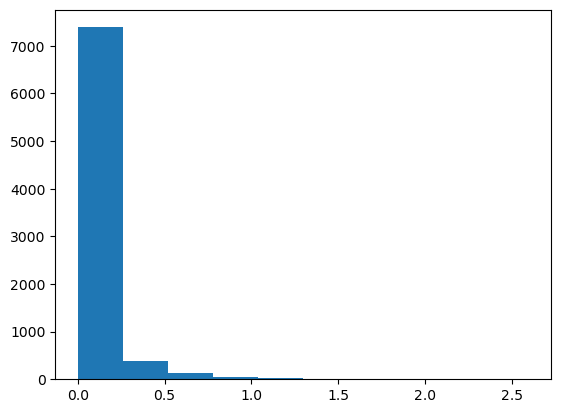

In [96]:
#hist_reco(metric) plots a histogram of the particles with the following metric.
#metric = 0 is rms; metric = 1 is n*variance; metric = 2 is rms/nhits; metric = 3 is rms/length 

hist_reco(3)

11
11
